In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
class KNNShapleyExplainer:
    # Konstruktor -model: KNN-Modell, -X_train: Trainingsdaten, -Y_train: Labels,
    def __init__(self, model, X_train, y_train, K=None):  # K: Anzahl Nachbarn
        # ist das Model wirklich ein KNeighborsClassifier?
        if not isinstance(model, KNeighborsClassifier):
            raise ValueError("Only sklearn's KNeighborsClassifier is supported.")
        # alles was ich in self. speichere bleibt auch für später erhalten
        self.model = model
        self.X_train = np.asarray(X_train)  # sorgt dafür dass es ein Numpy-Array ist
        self.y_train = np.asarray(y_train)
        # wenn ich ein K übergeben bekomme wird das genutz oder ich hols mir aus dem Modell
        self.K = K if K is not None else model.n_neighbors
        # stimmt die Anzahl der Trainingsdaten und Labels überein?
        if self.X_train.shape[0] != len(self.y_train):
            raise ValueError("Training features and labels must match.")

    # Berechnung SV für einen Testpunkt
    def _compute_single(self, x_test, y_test):
        # Berechnet Distanzen zwischen Testpunkt und allen Trainingspunkten
        distances = cdist(self.X_train, [x_test], metric="euclidean").flatten()
        # sortiere die Trainingspunkte vom nächsten bis zum weitesten Abstand
        sorted_idx = np.argsort(distances)
        N = len(sorted_idx)
        # N: Anzahl der Trainingspunkte, s: Platz für die Shapley-Werte in Sortierreihnfolge
        s = np.zeros(N)

        # Startpunkt der Rekursion: der weiteste Punkt bekommt 1/N falls er das richtige Label hat sonst 0
        last = sorted_idx[-1]
        s[-1] = int(self.y_train[last] == y_test) / N

        # SCHLEIFE FÜR REKURSIVE BERECHNUNG
        for i in reversed(range(N - 1)):  # durchläuft allte Punkte von hinten nach vorne
            idx_i = sorted_idx[i]  # holt sich den aktuellen und
            idx_next = sorted_idx[i + 1]  # den nächsten Punkt in der Sortierung
            # berehne den Einfluss-Unterschied (delta) zwischen aktuellem und nächstem Punkt, Unterschied wird auf K Nachbern normalisiert (1/K)-> ist das Label des aktuellen Punktes hilfreicher als das des nächsten
            delta = (int(self.y_train[idx_i] == y_test) - int(self.y_train[idx_next] == y_test)) / self.K
            s[i] = s[i + 1] + delta * (min(self.K, i + 1) / (i + 1))  # berechnet neuen SV für diesen Punkt
        # Werte aus s werden zurück in die Orginal-Reihnfolge der Trainingsdaten gelegt
        shapley = np.zeros(N)
        for i, idx in enumerate(sorted_idx):
            shapley[idx] = s[i]

        return shapley  # gibt SV für diesen einen Testpunkt zurück

    def explain(self, X_test, y_test):
        # Umwandlung in NumPy-Arrays
        X_test = np.asarray(X_test)
        y_test = np.asarray(y_test)
        # Prüft ob zu jedem Testpunkt auch ein Label gegeben ist
        if len(X_test) != len(y_test):
            raise ValueError("Mismatch between test inputs and labels.")
        # berechnet SV für jeden Testpunkt einzeln, Ergebnis ist eine Liste von Arrays (eins pro Testpunkt)
        shapley_matrix = [self._compute_single(x, y) for x, y in zip(X_test, y_test, strict=False)]
        return np.mean(shapley_matrix, axis=0)  # Mittelwert über alle Testpunkte (ein SV pro Trainingspunkt)



In [3]:
# lade die Daten
# df = pd.read_csv(r"C:\Users\Marwa\shapiq-c\shapiq\data\adult_census.csv")
df = pd.read_csv(r"..\shapiq\data\adult_census.csv")
df = df.dropna()

# benutze numerische Features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_cols].values

# Kodierung des Zielwerts (Labels):
if "income" in df.columns:
    y = (df["income"] == ">50K").astype(int).values
else:
    y = df.iloc[:, -1].astype("category").cat.codes.values

# Features normalisieren
X = StandardScaler().fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



In [4]:
# trainiere KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# inizialisiere KNN-Shapley Explainer
explainer = KNNShapleyExplainer(knn, X_train, y_train)

# berechne SV für 150 Testpunkte
shapley_vals = explainer.explain(X_test[:150], y_test[:150])


Shapley values for training points (average over 150 test samples):
[8.01341910e-06 1.83469784e-05 2.70304273e-05 ... 2.63865829e-05
 4.59122408e-05 1.76467800e-04]


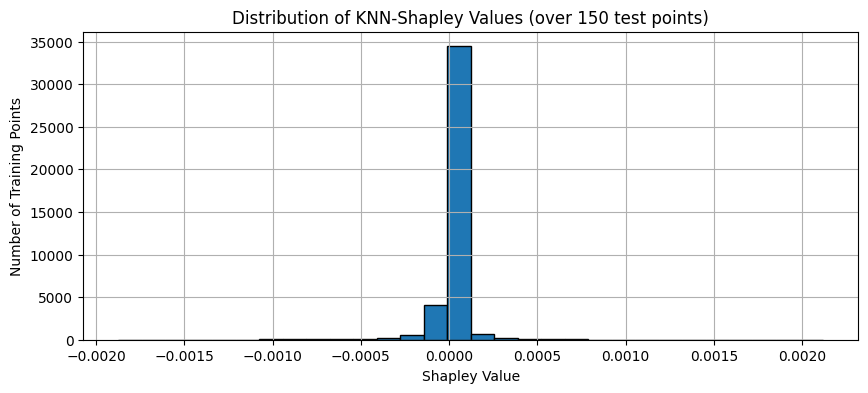

In [5]:
# Werte ausgeben und visualisieren
print("Shapley values for training points (average over 150 test samples):")
print(shapley_vals)

# Histogramm
plt.figure(figsize=(10, 4))
plt.hist(shapley_vals, bins=30, edgecolor="black")
plt.title("Distribution of KNN-Shapley Values (over 150 test points)")
plt.xlabel("Shapley Value")
plt.ylabel("Number of Training Points")
plt.grid(True)
plt.show()
